## Conditional Spectrum (CS) Based Record Selection for Multiple-Stripe Analysis (MSA) Upon Carrying out Probabilistic Seismic Hazard Analyss (PSHA) via OpenQuake
Created on: 26/08/2021

Author: Volkan Ozsarac

Affiliation: University School for Advanced Studies IUSS Pavia

Earthquake Engineering PhD Candidate

email:  volkan.ozsarac@iusspavia.it

In [1]:
from EzGM.Selection import conditional_spectrum
from EzGM import OQProc
from EzGM.Utility import file_manager, RunTime
from time import time
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Acquire the run start time
startTime = time()

### 1) Perform PSHA via OpenQuake

In [3]:
# %% Hazard Analysis via OpenQuake
# Set path to OpenQuake model .ini file path
parent_path = os.path.dirname(os.path.realpath(""))
oq_model = os.path.join(parent_path,'input files','OQ_Model') # this is the folder where oq model is located
oq_ini = 'job.ini' # this is .ini file used to run hazard model via openquake

# Set command to call OpenQuake
oq = 'oq'

# Directory to place post-processing results
post_dir = 'OQproc_Outputs'

# Read .ini file for post-processing purposes
with open(os.path.join(oq_model,oq_ini)) as f:
    info = f.readlines()
    for line in info:
        if line.startswith('poes'):
            poes = [float(poe) for poe in
                    line.split('\n')[0].split('=')[1].split(',')]
        if line.startswith('export_dir'):
            results_dir = os.path.join(oq_model, line.split('\n')[0].split('=')[1].strip())
        if line.startswith('mag_bin_width'):
            exec(line.strip())
        if line.startswith('distance_bin_width'):
            exec(line.strip())
        if line.startswith('reference_vs30_value'):
            exec(line.strip())


# Create the export directory for analysis results
file_manager.create_dir(results_dir)

# Create the directory for processed results
file_manager.create_dir(post_dir)

# Run the analysis via system command
cwd = os.getcwd() # Current working directory
os.chdir(oq_model) # Change directory, head to OQ_model folder
os.system(oq + ' engine --run ' + oq_ini + ' --exports csv')
os.chdir(cwd) # go back to the previous working directory

[2021-10-27 14:51:23 #10 INFO] volkan running /mnt/441AF34D1AF33A8E/GitHub/EzGM/Examples/input files/OQ_Model/job.ini [--hc=None]
[2021-10-27 14:51:23 #10 INFO] Using engine version 3.11.0
[2021-10-27 14:51:24 #10 WARNING] Version v3.11.4 of the engine is available, but you are still using version 3.11.0
[2021-10-27 14:51:24 #10 WARNING] Using 8 cores on volkan-GL702VMK
[2021-10-27 14:51:24 #10 INFO] Validated ssmLT.xml in 0.00 seconds
[2021-10-27 14:51:24 #10 INFO] Checksum of the input files: 730455054
[2021-10-27 14:51:24 #10 INFO] Reading the risk model if present
[2021-10-27 14:51:24 #10 INFO] Read N=1 hazard sites and L=15 hazard levels
[2021-10-27 14:51:24 #10 INFO] Total number of logic tree paths = 1
[2021-10-27 14:51:24 #10 INFO] Reading the source model(s) in parallel
[2021-10-27 14:51:24 #10 INFO] read_source_model 100% [1 submitted, 0 queued]
[2021-10-27 14:51:24 #10 INFO] Received {'/mnt/441AF34D1AF33A8E/GitHub/EzGM/Examples/input files/OQ_Model/ssm.xml': '19.72 KB'} in 0

  id | name
  36 | Disaggregation Outputs
  37 | Full Report
  38 | Hazard Curves
  39 | Hazard Maps
  40 | Input Files


### 2) Post-process PSHA results

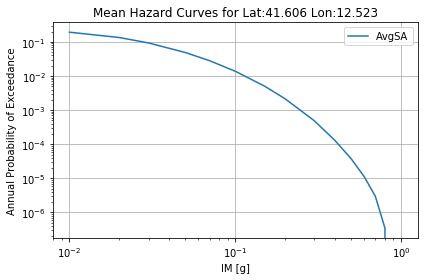

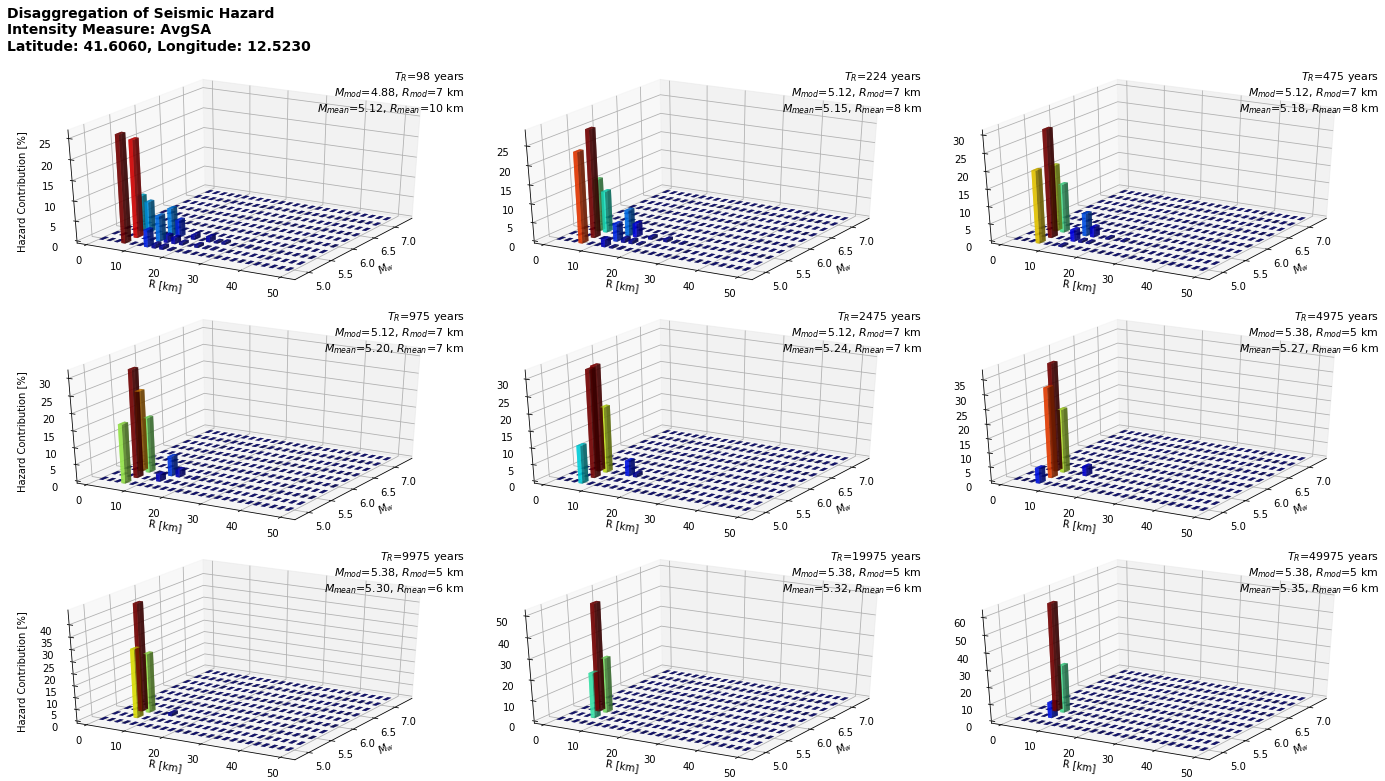

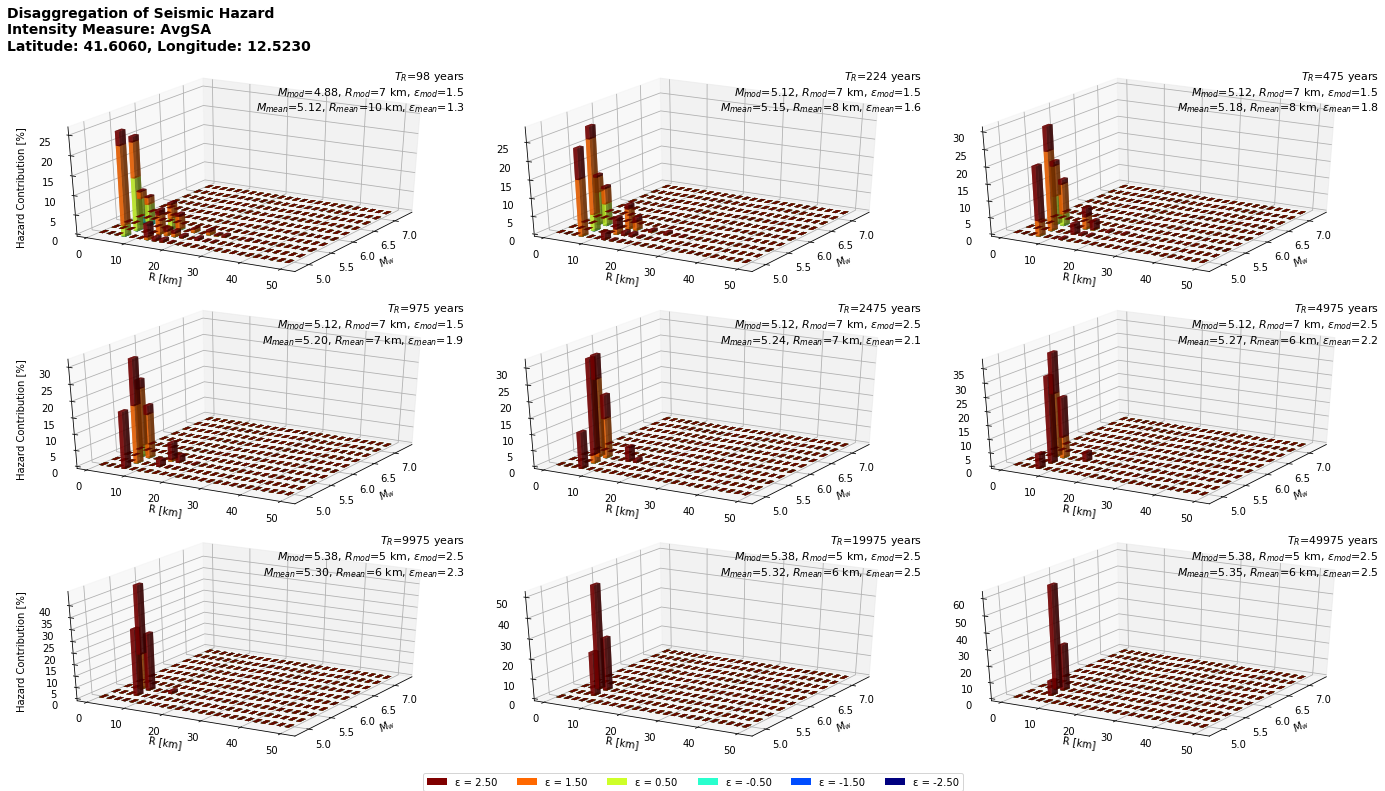

In [4]:
# Extract and plot hazard curves in a reasonable format
OQProc.hazard(poes, results_dir, post_dir)

# Extract and plot disaggregation results by M and R
OQProc.disagg_MR(mag_bin_width, distance_bin_width, poes, results_dir, post_dir, n_rows=3)

# Extract and plot disaggregation results by M, R and epsilon
OQProc.disagg_MReps(mag_bin_width, distance_bin_width, poes, results_dir, post_dir, n_rows=3)

### 3) Select the ground motions for different return periods, IM=AvgSA(T*)

In [5]:
ims = []
for file in os.listdir(post_dir):
    if file.startswith('imls'):
        ims.append(file.split('_')[1].split('.')[0])

for im in ims:  # for each im in the im list
    # read hazard and disaggregation info
    imls = np.loadtxt(os.path.join(post_dir, 'imls_' + im + '.out'))
    mean_mags = np.loadtxt(os.path.join(post_dir, 'mean_mags_' + im + '.out'))
    mean_dists = np.loadtxt(os.path.join(post_dir, 'mean_dists_' + im + '.out'))

    # 1.) Initialize the conditional_spectrum object for record selection, check which parameters are required for the gmpe you are using.
    cs = conditional_spectrum(Tstar=np.arange(0.1, 1.1, 0.1), gmpe='BooreEtAl2014', database='NGA_W2', pInfo=1)

    for i in range(len(poes)):
        # 2.) Create target spectrum
        cs.create(site_param={'vs30': reference_vs30_value}, rup_param={'rake': 0.0, 'mag': [mean_mags[i]]},
                  dist_param={'rjb': [mean_dists[i]]}, Hcont=None, T_Tgt_range=[0.05, 2.5],
                  im_Tstar=imls[i], epsilon=None, cond=1, useVar=1, corr_func='baker_jayaram',
                  outdir=os.path.join('EzGM_Outputs_' + im, 'POE-' + str(poes[i]) + '-in-50-years'))

        # 3.) Select the ground motions
        cs.select(nGM=25, selection=1, Sa_def='RotD50', isScaled=1, maxScale=2.5,
                  Mw_lim=None, Vs30_lim=None, Rjb_lim=None, fault_lim=None, nTrials=20,
                  weights=[1, 2, 0.3], seedValue=0, nLoop=2, penalty=1, tol=10)

        # Plot the target spectrum, simulated spectra and spectra of selected records
        cs.plot(tgt=0, sim=0, rec=1, save=1, show=0)
        plt.close('all')

        # 4.) If database == 'NGA_W2' you can first download the records via nga_download method
        # from NGA-West2 Database [http://ngawest2.berkeley.edu/] and then use write method
        # You should enter correct credentials to download the records
        # cs.ngaw2_download(username = 'example_username@email.com', pwd = 'example_password123456', sleeptime = 3)

        # 5.) If you have records already inside recs_f\database.zip\database or
        # downloaded records for database = NGA_W2 case, write whatever you want,
        # the object itself, selected and scaled time histories
        cs.write(obj=1, recs=0, recs_f='')


For the selected gmpe;
The mandatory input distance parameters are ['rjb']
The mandatory input rupture parameters are ['mag', 'rake']
The mandatory input site parameters are ['vs30']
The defined intensity measure component is Average Horizontal (RotD50)
The defined tectonic region type is Active Shallow Crust

Target spectrum is created.
Ground motion selection is finished.
For T ∈ [0.05 - 2.50]
Max error in median = 5.90 %
Max error in standard deviation = 9.98 %
The errors are within the target 10 percent %
Finished writing process, the files are located in
/mnt/441AF34D1AF33A8E/GitHub/EzGM/Examples/binder/EzGM_Outputs_AvgSA/POE-0.4-in-50-years
Target spectrum is created.
Ground motion selection is finished.
For T ∈ [0.05 - 2.50]
Max error in median = 4.88 %
Max error in standard deviation = 8.30 %
The errors are within the target 10 percent %
Finished writing process, the files are located in
/mnt/441AF34D1AF33A8E/GitHub/EzGM/Examples/binder/EzGM_Outputs_AvgSA/POE-0.2-in-50-years
Ta

In [6]:
# Calculate the total time passed
RunTime(startTime)

Run time: 0 hours: 4 minutes: 0.92 seconds
